In [21]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf


from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix

from yellowbrick.classifier import ROCAUC
from sklearn.metrics import roc_curve, auc


from keras.utils.np_utils import to_categorical

from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load all sklearn models
with open("./model/all_sklearn_lumbar.pkl", "rb") as f:
    sklearn_models = pickle.load(f)

# Load all deep learning models
three_model = load_model("./model/3_layers_lumbar.h5")
five_model = load_model("./model/5_layers_lumbar.h5")
seven_model = load_model("./model/7_layers_lumbar.h5")
sevenD_model = load_model("./model/7_layers_with_dropout_lumbar.h5")

# Load input scaler
with open("./model/input_scaler_lumbar.pkl", "rb") as f:
    sc = pickle.load(f)

In [3]:
def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data


def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

In [5]:
# load dataset
test_df = describe_dataset("./lumbar_test.csv")

# Categorizing label
test_df.loc[test_df["label"] == "lumbar_correct", "label"] = 0
test_df.loc[test_df["label"] == "lumbar_error", "label"] = 1

# Standard Scaling of features
test_x = test_df.drop("label", axis = 1)
test_x = pd.DataFrame(sc.transform(test_x))

test_y = test_df["label"].astype('int')

# # Converting prediction to categorical
test_y_cat = to_categorical(test_y)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v']
Number of rows: 1980 
Number of columns: 53

Labels: 
lumbar_correct    1660
lumbar_error       320
Name: label, dtype: int64

Missing values: False


In [6]:
testset_final_results = []

for name, model in sklearn_models.items():
    # Evaluate model
    model_results = model.predict(test_x)

    p_score = precision_score(test_y, model_results, average="macro")
    a_score = accuracy_score(test_y, model_results)
    r_score = recall_score(test_y, model_results, average="macro")
    f1_score_result = f1_score(test_y, model_results, average="macro")
    cm = confusion_matrix(test_y, model_results, labels=[0, 1])
    testset_final_results.append(( name,  p_score, r_score, a_score, f1_score_result, cm ))


sklearn_eval = pd.DataFrame(testset_final_results, columns=["Model", "Precision Score", "Recall Score", "Accuracy Score", "F1 Score", "Confusion Matrix"])

sklearn_eval

,Model,Precision Score,Recall Score,Accuracy Score,F1 Score,Confusion Matrix
0,LR,0.812169,0.748927,0.889899,0.774641,"[[1589, 71], [147, 173]]"
1,SVC,0.812609,0.716905,0.884848,0.750874,"[[1602, 58], [170, 150]]"
2,KNN,0.756213,0.689721,0.864646,0.714449,"[[1574, 86], [182, 138]]"
3,DTC,0.672424,0.683095,0.819697,0.677406,"[[1469, 191], [166, 154]]"
4,SGDC,0.807493,0.697797,0.880303,0.733744,"[[1606, 54], [183, 137]]"
5,NB,0.696010,0.725697,0.829798,0.708578,"[[1460, 200], [137, 183]]"
6,RF,0.825967,0.729047,0.890404,0.764027,"[[1606, 54], [163, 157]]"


In [7]:
test_set_results = []

model_paths = ["./model/3_layers_lumbar.h5", 
               "./model/5_layers_lumbar.h5", 
               "./model/7_layers_lumbar.h5", 
               "./model/7_layers_with_dropout_lumbar.h5"]

for path in model_paths:
    model = load_model(path)

    # Evaluate model
    predict_x = model.predict(test_x, verbose=False) 
    y_pred_class = np.argmax(predict_x, axis=1)
    y_test_class = np.argmax(test_y_cat, axis=1)

    cm = confusion_matrix(y_test_class, y_pred_class, labels=[0, 1, 2])
    p_score = precision_score(y_test_class, y_pred_class, average="weighted")
    a_score = accuracy_score(y_test_class, y_pred_class)
    r_score = recall_score(y_test_class, y_pred_class, average="weighted")
    f1_score_result = f1_score(y_test_class, y_pred_class, average="weighted")
    
    test_set_results.append(( path,  p_score, r_score, a_score, f1_score_result, cm ))

dp_eval = pd.DataFrame(test_set_results, columns=["Model Path", "Precision Score", "Recall Score", "Accuracy Score", "F1 Score", "Confusion Matrix"])

dp_eval

,Model Path,Precision Score,Recall Score,Accuracy Score,F1 Score,Confusion Matrix
0,./model/3_layers_lumbar.h5,0.862959,0.863131,0.863131,0.863045,"[[1525, 135, 0], [136, 184, 0], [0, 0, 0]]"
1,./model/5_layers_lumbar.h5,0.869608,0.877273,0.877273,0.872309,"[[1567, 93, 0], [150, 170, 0], [0, 0, 0]]"
2,./model/7_layers_lumbar.h5,0.872175,0.873737,0.873737,0.872925,"[[1540, 120, 0], [130, 190, 0], [0, 0, 0]]"
3,./model/7_layers_with_dropout_lumbar.h5,0.880833,0.884848,0.884848,0.882532,"[[1561, 99, 0], [129, 191, 0], [0, 0, 0]]"


In [8]:
eval_df = pd.concat([sklearn_eval, dp_eval])
eval_df = eval_df.sort_values(by=['F1 Score'], ascending=False).reset_index(drop=True)
eval_df.to_csv(f"evaluation.csv", sep=',', encoding='utf-8', index=False)
eval_df

,Model,Precision Score,Recall Score,Accuracy Score,F1 Score,Confusion Matrix,Model Path
0,NaN,0.880833,0.884848,0.884848,0.882532,"[[1561, 99, 0], [129, 191, 0], [0, 0, 0]]",./model/7_layers_with_dropout_lumbar.h5
1,NaN,0.872175,0.873737,0.873737,0.872925,"[[1540, 120, 0], [130, 190, 0], [0, 0, 0]]",./model/7_layers_lumbar.h5
2,NaN,0.869608,0.877273,0.877273,0.872309,"[[1567, 93, 0], [150, 170, 0], [0, 0, 0]]",./model/5_layers_lumbar.h5
3,NaN,0.862959,0.863131,0.863131,0.863045,"[[1525, 135, 0], [136, 184, 0], [0, 0, 0]]",./model/3_layers_lumbar.h5
4,LR,0.812169,0.748927,0.889899,0.774641,"[[1589, 71], [147, 173]]",NaN
5,RF,0.825967,0.729047,0.890404,0.764027,"[[1606, 54], [163, 157]]",NaN
6,SVC,0.812609,0.716905,0.884848,0.750874,"[[1602, 58], [170, 150]]",NaN
7,SGDC,0.807493,0.697797,0.880303,0.733744,"[[1606, 54], [183, 137]]",NaN
8,KNN,0.756213,0.689721,0.864646,0.714449,"[[1574, 86], [182, 138]]",NaN
9,NB,0.696010,0.725697,0.829798,0.708578,"[[1460, 200], [137, 183]]",NaN


In [9]:
best_model = sklearn_models["LR"]
y_predictions = best_model.predict(test_x)

p_score = precision_score(test_y, y_predictions, labels=[0, 1], average=None)
r_score = recall_score(test_y, y_predictions, labels=[0, 1], average=None)
f1_score_result = f1_score(test_y, y_predictions, labels=[0, 1], average=None)

p_score, r_score, f1_score_result

(array([0.91532258, 0.70901639]),
 array([0.95722892, 0.540625  ]),
 array([0.93580683, 0.61347518]))

In [10]:
(0.936 + 0.613) / 2

0.7745

In [11]:
best_model01 = sevenD_model
y_predictions = best_model01.predict(test_x)

# convert continuous values to discrete labels using a threshold of 0.5
y_predictions_labels = (y_predictions >= 0.5).argmax(axis=-1)

p_score = precision_score(test_y, y_predictions_labels, labels=[0, 1], average=None)
r_score = recall_score(test_y, y_predictions_labels, labels=[0, 1], average=None)
f1_score_result = f1_score(test_y, y_predictions_labels, labels=[0, 1], average=None)

p_score, r_score, f1_score_result

62/62 [==============================] - 0s 4ms/step


(array([0.92366864, 0.65862069]),
 array([0.94036145, 0.596875  ]),
 array([0.9319403 , 0.62622951]))

In [12]:
(0.932 + 0.626) / 2

0.779

<AxesSubplot:>

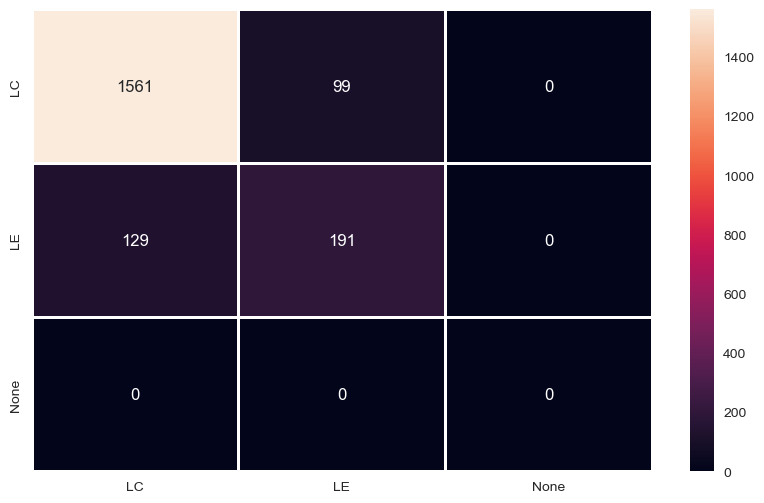

In [27]:
LR_cm = dp_eval[dp_eval["Model Path"] == './model/7_layers_with_dropout_lumbar.h5']["Confusion Matrix"].values[0]


cm_array_df = pd.DataFrame(LR_cm, index=["LC", "LE", "None"], columns=["LC", "LE", "None"])

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_array_df, linewidths=1, annot=True, ax=ax, fmt='g')

In [19]:
def to_labels(y_pred, y_pred_proba, threshold):
    '''Return prediction taking confidence threshold into account'''
    results = []

    for index, predicted_class in enumerate(y_pred):
        prediction_probabilities = y_pred_proba[index]
        class_prediction_probability = round(prediction_probabilities[np.argmax(prediction_probabilities)], 2)

        results.append(predicted_class if class_prediction_probability >= threshold else -1)
    
    return results


def calculate_correlation_score_confidence(test_x, test_y):
    '''Calculate correlation between Precision score/Recall score/F1 score and confidence threshold'''
    y_predictions = best_model01.predict(test_x)
    y_predict_logits = y_predictions
    y_predict_proba = tf.nn.softmax(y_predictions)

    thresholds = list(np.arange(0, 1.01, 0.01))
    f1_scores = []
    for threshold in thresholds:
        y_pred_bin = (y_predict_proba[:,1] > threshold).numpy().astype(int)
        f1 = f1_score(test_y, y_pred_bin, average=None)
        f1_scores.append(f1)

    return thresholds, f1_scores

62/62 [==============================] - 0s 3ms/step


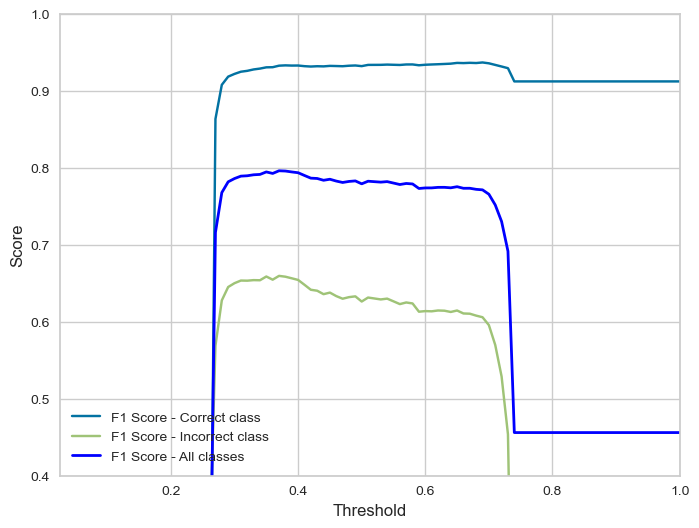

In [23]:
thresholds, f1_scores = calculate_correlation_score_confidence(test_x, test_y)

first_class = [ el[0] for el in f1_scores ]
second_class = [ el[1] for el in f1_scores ]
all_classes = [(el[0] + el[1]) / 2 for el in f1_scores]

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(thresholds, first_class, label = "F1 Score - Correct class")
plt.plot(thresholds, second_class, label = "F1 Score - Incorrect class")
plt.plot(thresholds, all_classes, label = "F1 Score - All classes", linewidth=2.0, color="blue")
plt.legend(loc = 'lower left')
plt.ylim([0.4, 1])
plt.xlim([0.025, 1])
plt.xlabel("Threshold", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
# plt.axvline(thresholds[np.argmin(abs(precision-recall))], color="k", ls = "--")
# plt.title(label = F"Threshold = {thresholds[np.argmin(abs(precision-recall))]:.3f}", fontsize = 12)
plt.show()

62/62 [==============================] - 0s 3ms/step
Optimal Threshold: 0.01025671698153019


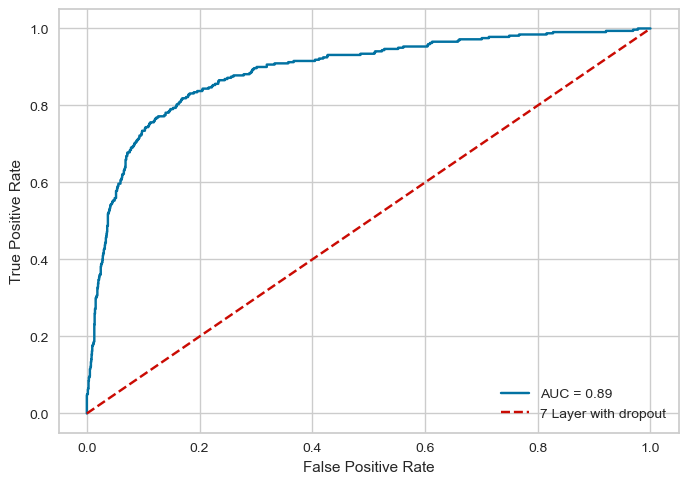

In [29]:
# calculate the fpr and tpr for all thresholds of the classification
probs = best_model01.predict(test_x)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# method I: plt
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--', label="7 Layer with dropout")
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()